In [1]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from copy import deepcopy
from matplotlib.patches import Rectangle, Patch
from rdkit import Chem, Geometry
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw, AllChem, rdFMCS, Descriptors
from rdkit.Chem import rdFingerprintGenerator

# Parse input

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-i','--input', help = "The library file to be prepared", required=True)
parser.add_argument('-c','--cutoff', help = "The library file to be prepared", default=0.4, required=False)
args = parser.parse_args(['-i', 'P09238_target_driven_VS_top_1_ten_thousandth_percent_VS_hits.csv'])

# Make functions

In [3]:
def get_compounds(input_csv):
    compound_df = pd.read_csv(input_csv)
    compounds = []
    for _, chembl_id, smiles in compound_df[["comp_id", "smiles"]].itertuples():
        compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
    return compounds

In [4]:
def get_properties(df,column):
    print("Calcuating properties...")
    MolWt=[]
    MolLogP=[]
    NumHAcceptors=[]
    NumHDonors=[]
    NumRotatableBonds=[]
    TPSA=[]
    QED=[]
    for i in df[column]:
        m = Chem.MolFromSmiles(i)
        MolWt.append(Descriptors.MolWt(m))
        MolLogP.append(Descriptors.MolLogP(m))
        NumHAcceptors.append(Descriptors.NumHAcceptors(m))
        NumHDonors.append(Descriptors.NumHDonors(m))
        NumRotatableBonds.append(Descriptors.NumRotatableBonds(m))
        TPSA.append(Descriptors.TPSA(m))
        QED.append(Chem.QED.qed(m))
        #print(i)

    df['MolWt']=MolWt
    df['MolLogP']=MolLogP
    df['NumHAcceptors']=NumHAcceptors
    df['NumHDonors']=NumHDonors
    df['NumRotatableBonds']=NumRotatableBonds
    df['TPSA']=TPSA
    df['QED']=QED
    return df

In [5]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
  
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [6]:
def cluster_fingerprints(fingerprints, cutoff=0.4):
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [7]:
def get_clusters_with_smiles(input_csv, cutoff=0.4):
    compounds = get_compounds(input_csv)
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol, _ in compounds]
    clusters = cluster_fingerprints(fingerprints, cutoff)
    cluster_data = []
    for cluster_idx, cluster in enumerate(clusters):
        for molecule_idx in cluster:
            mol, chembl_id = compounds[molecule_idx]
            smiles = Chem.MolToSmiles(mol)
            cluster_data.append({"smiles": smiles, "chembl_id": chembl_id, "cluster": cluster_idx})
    
    clusters_df = pd.DataFrame(cluster_data)
    return clusters_df

In [8]:
def plot_cluster_analysis(df,selected_clusters=[0, 1, 2, 3, 4],
    save_path=None):

    plt.style.use("seaborn-white")
    mpl.rcParams["text.color"] = "black"
    mpl.rcParams["axes.labelcolor"] = "black"
    mpl.rcParams["xtick.color"] = "black"
    mpl.rcParams["ytick.color"] = "black"
    mpl.rcParams["legend.edgecolor"] = "black"
    mpl.rcParams["axes.labelsize"] = 15
    mpl.rcParams["xtick.labelsize"] = 13
    mpl.rcParams["ytick.labelsize"] = 13
    mpl.rcParams["legend.fontsize"] = 13
    mpl.rcParams["figure.titlesize"] = 20

    cluster_colors = [
            {'edge': '#000000', 'bar': '#F36735'},
            {'edge': '#000000', 'bar': '#8439E0'},
            {'edge': '#000000', 'bar': '#58BB1E'},
            {'edge': '#000000', 'bar': '#E8AF45'},
            {'edge': '#000000', 'bar': '#9F97A9'}]
    
    properties = ['MolWt', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 
                  'NumRotatableBonds', 'TPSA', 'QED']

    df_top = df[df['cluster'].isin(selected_clusters)]

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    compound_counts = df_top['cluster'].value_counts().sort_index()
    bar_colors = [c['bar'] for c in cluster_colors]
    bar_edges = [c['edge'] for c in cluster_colors]
    x_labels = compound_counts.index.astype(str)

    axes[0].bar(
        x_labels,
        compound_counts.values,
        color=bar_colors,
        edgecolor=bar_edges,
        linewidth=1.5,
        width=0.6
    )
    axes[0].set_xlabel("Cluster ID")
    axes[0].set_ylabel("Compound Count")
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.4)


    legend_patches = [Patch(facecolor=c['bar'], edgecolor=c['edge'], label=f'Cluster {i}') 
                      for i, c in enumerate(cluster_colors)]
    axes[0].legend(handles=legend_patches, frameon=False, loc='upper right')


    for i, prop in enumerate(properties):
        ax = axes[i+1]
        for j, cluster in enumerate(selected_clusters):
            cluster_data = df_top[df_top['cluster'] == cluster][prop].dropna()
            if not cluster_data.empty:
                sns.kdeplot(
                    cluster_data,
                    ax=ax,
                    color=cluster_colors[j]['bar'],
                    linewidth=2.0,
                    fill=True,
                    alpha=0.35
                )
        ax.set_xlabel(prop)
        ax.set_ylabel('Density')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.suptitle(
        "Cluster Analysis: Compound Counts and Molecular Property Distributions",
        weight='bold',
        y=1
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])


    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    for cluster in fps_clusters:

        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [10]:
def plot_intra_cluster_similarity(intra_sim, save_path=None, dpi=300):
    plt.style.use("seaborn-white")
    fig, ax = plt.subplots(figsize=(8, 6))
    indices = list(range(len(intra_sim)))

    cluster_colors = [
        {'violin_facecolor': '#ff9671', 'violin_edgecolor': '#F7845B', 'jitter_color': '#ff9671', 'box_color': '#F36735'},
        {'violin_facecolor': '#c493ff', 'violin_edgecolor': '#A360F5', 'jitter_color': '#c493ff', 'box_color': '#8439E0'},
        {'violin_facecolor': '#9DEF6D', 'violin_edgecolor': '#6ED035', 'jitter_color': '#9DEF6D', 'box_color': '#58BB1E'},
        {'violin_facecolor': '#FFC75F', 'violin_edgecolor': '#E8AF45', 'jitter_color': '#FFC75F', 'box_color': '#E8AF45'},
        {'violin_facecolor': '#B0A8B9', 'violin_edgecolor': '#9F97A9', 'jitter_color': '#B0A8B9', 'box_color': '#9F97A9'}
    ]



    for i in indices:

        color_set = cluster_colors[i % len(cluster_colors)]
        

        violin = ax.violinplot([intra_sim[i]], positions=[i], showmeans=False, showmedians=False, showextrema=False, widths=0.7)
        
        for body in violin['bodies']:
            body.set_facecolor(color_set['violin_facecolor'])
            body.set_alpha(0.6)
            body.set_edgecolor(color_set['violin_edgecolor'])
            body.set_linewidth(2)
        

        rect = Rectangle((i - 0.4, ax.get_ylim()[0]), 0.4, ax.get_ylim()[1] - ax.get_ylim()[0],
                     facecolor='white', edgecolor='none', zorder=2)
        ax.add_patch(rect)
        

        jitter = np.random.uniform(i - 0.4, i - 0.1, size=len(intra_sim[i]))
        ax.scatter(jitter, intra_sim[i], color=color_set['jitter_color'], alpha=0.6, s=5, zorder=3)


    boxplot_parts = ax.boxplot(intra_sim, positions=np.array(indices), widths=0.1, patch_artist=True, showfliers=False)
    
    for i, (box, color_set) in enumerate(zip(boxplot_parts['boxes'], cluster_colors)):
        box.set_color(color_set['box_color'])
        box.set_alpha(0.8)
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
    
    for i, median in enumerate(boxplot_parts['medians']):
        median.set_color('#000000')
        median.set_linestyle('-')
    
    for i, whisker in enumerate(boxplot_parts['whiskers']):
        whisker.set_color('#000000')
        whisker.set_linestyle('-')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.set_ylabel("Tanimoto Similarity", fontsize=15, weight='bold')
    ax.set_title("Intra-cluster Tanimoto Similarity", fontsize=15, weight='bold')

    xtick_labels = [f"Cluster {i}" for i in indices]

    ax.set_xticks(indices)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right', color='black', fontsize=13)

    ax.tick_params(axis='x', direction='out', length=6, width=1, color='black', labelsize=13)
    ax.tick_params(axis='y', direction='out', length=6, width=1, color='black', labelsize=13)

    ax.set_ylim(0.3,1.05,0.1)
    ax.tick_params(axis='y', labelsize=15, colors='black')

    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    

In [11]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=False, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)

    pattern = Chem.MolFromSmarts(mcs.smartsString)
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

In [12]:
def process_cluster(cluster_indices, compounds, cluster_id, num_to_display=5, save_png=True):
    print(f"Ten molecules from cluster {cluster_id }:")

    mols = [compounds[i][0] for i in cluster_indices[:num_to_display]]

    sdf_path = f"molecule_set_cluster_{cluster_id}.sdf"
    sdf_writer = Chem.SDWriter(sdf_path)
    for index in cluster_indices:
        mol, label = compounds[index]
        mol.SetProp("_Name", label)
        sdf_writer.write(mol)
    sdf_writer.close()

    supplier = Chem.ForwardSDMolSupplier(sdf_path)
    mols = [mol for mol in supplier if mol is not None]
    mcs = rdFMCS.FindMCS(mols)

    img = highlight_molecules(mols, mcs, num_to_display, label=True, useSVG=False)
    display(img)

    if save_png:
        png_path = f"mcs_cluster_{cluster_id}.png"
        with open(png_path, "wb") as f:
            f.write(img.data)

# Use functions

In [13]:
compounds = get_compounds(args.input)
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]
clusters = cluster_fingerprints(fingerprints, cutoff=0.4)
cluster_data = []
for cluster_idx, cluster in enumerate(clusters):
    for molecule_idx in cluster:
        mol, chembl_id = compounds[molecule_idx]
        smiles = Chem.MolToSmiles(mol)
        cluster_data.append({"smiles": smiles, "chembl_id": chembl_id, "cluster": cluster_idx})
clusters_df = pd.DataFrame(cluster_data)
clusters_df = get_properties(clusters_df, "smiles")

Calcuating properties...


In [14]:
mol_fps_per_cluster = []
for cluster in clusters[:5]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

intra_sim = intra_tanimoto(mol_fps_per_cluster)

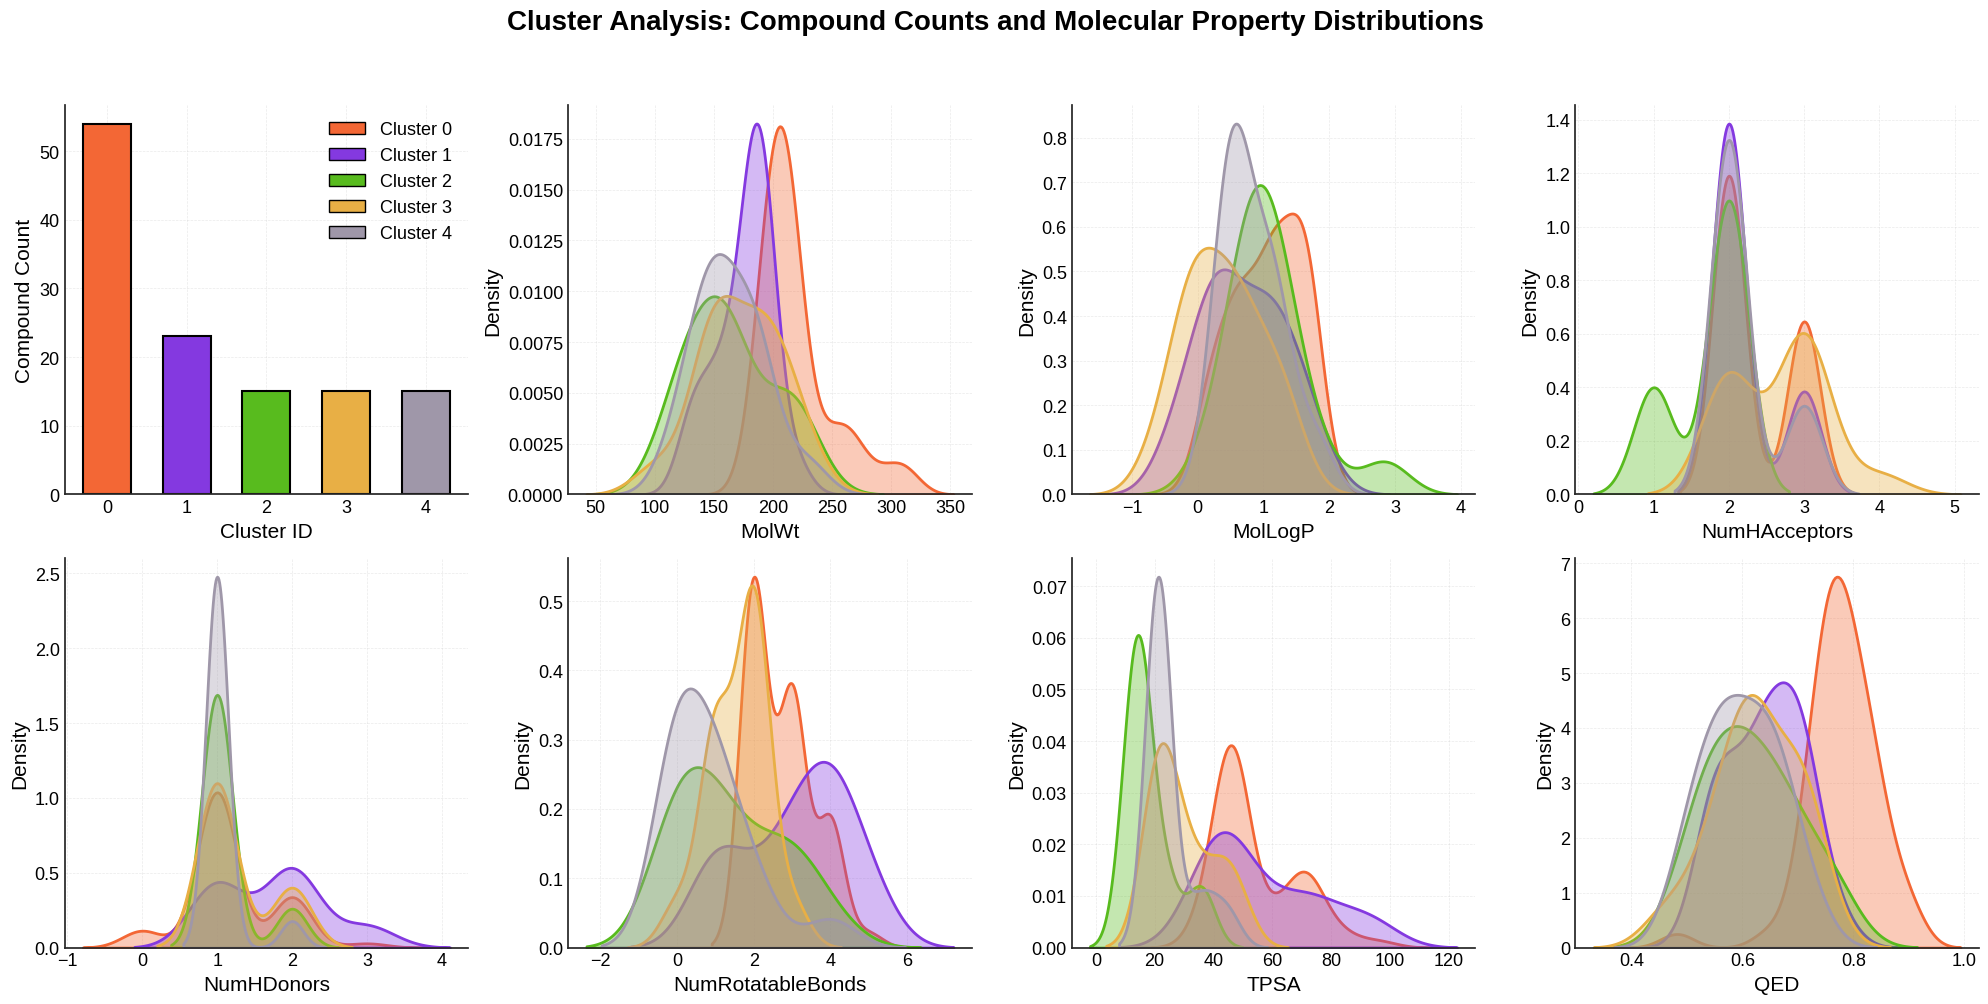

In [15]:
plot_cluster_analysis(df=clusters_df, save_path='cluster_analysis.png')

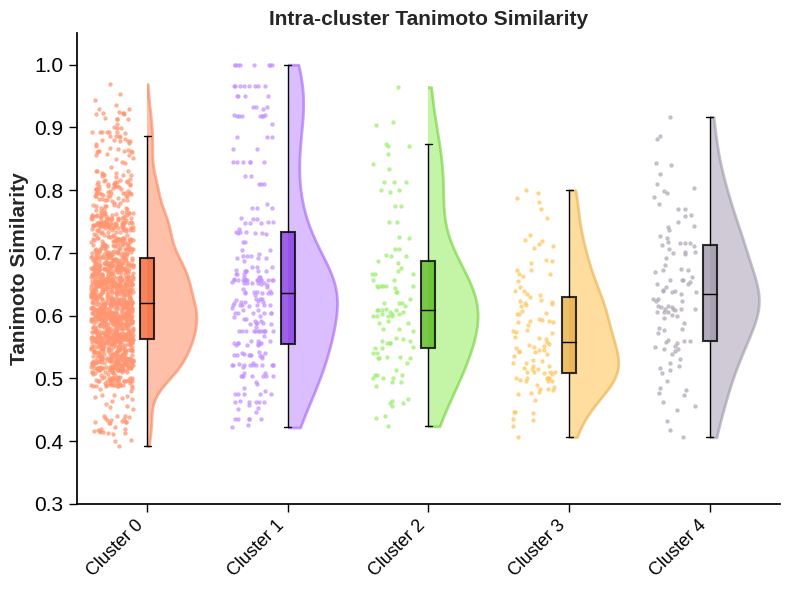

In [16]:
plot_intra_cluster_similarity(intra_sim, save_path="intra_cluster_similarity.png")

Ten molecules from cluster 0:


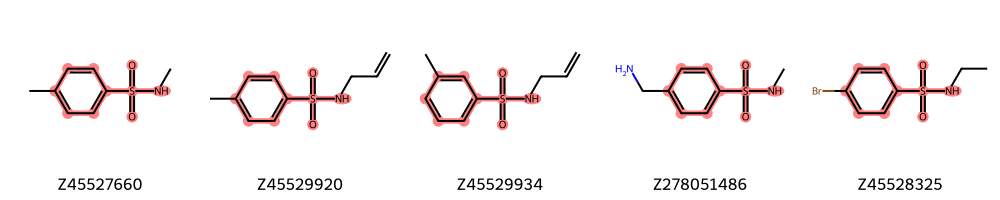

Ten molecules from cluster 1:


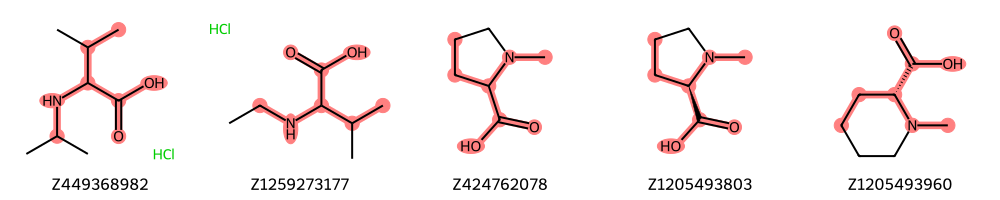

Ten molecules from cluster 2:


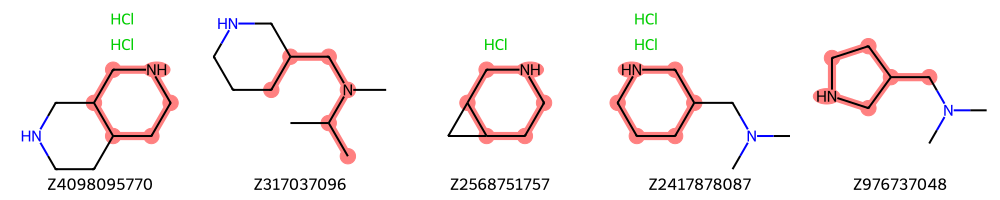

Ten molecules from cluster 3:


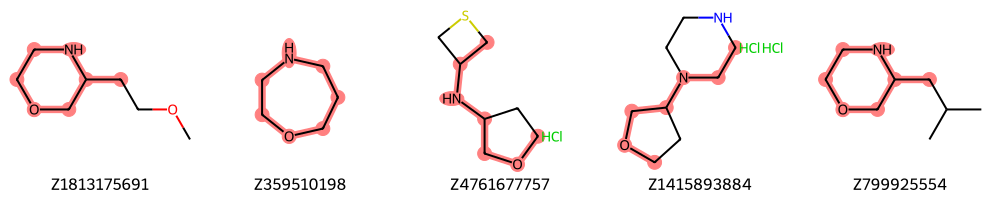

Ten molecules from cluster 4:


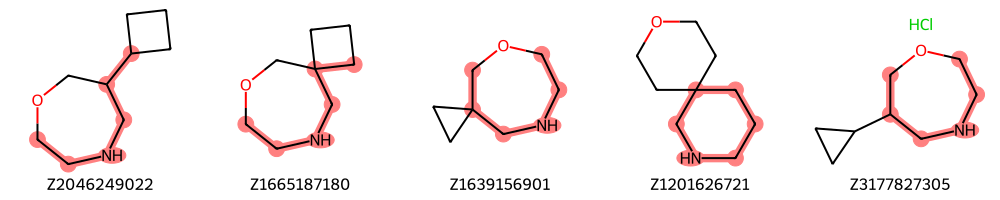

In [17]:
for cluster_id in range(5):  
    process_cluster(clusters[cluster_id], compounds, cluster_id)

# Example